# Projeto: Classificação de Redes Complexas

*Baseado nas aulas e códigos disponibilizados pelo professor.*

# Grupo:

**Alvaro Valentim P M Bandeira - 10392150**

**Débora Mayumi Rissato - 5288223**

**Douglas Decicino de Andrade - 10883512**

**Rafaela Silva - 9292372**

**Renan Silva Chun - 10691817**

# Objetivo:

Fazer a classificação das redes usando os modelos e medidas que aprendemos na aula, para 3 redes biológicas, 3 redes sociais e 3 redes tecnológicas, com o intuito de verificar se a hipótese de que "*redes do mesmo tipo seguem o mesmo modelo*", é verdadeira, identificando as principais diferenças dos modelos.  

# Medidas:

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
import time

Começaremos desenvolvendo uma função que calcula todas as medidas com as quais vamos trabalhar:

In [18]:
#função da distribuição de grau
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())
    maxk = np.max(vk)
    mink = np.min(min)
    kvalues= np.arange(0,maxk+1) 
    Pk = np.zeros(maxk+1) 
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk)
    return kvalues,Pk

In [16]:
#função dos momentos
def momment_of_degree_distribution(G,m):
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M    

In [19]:
#função da entropia de Shannon
def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H

In [20]:
#função que calcula todas as medidas
def medidas(G):
    k1 = momment_of_degree_distribution(G,1) #primeiro momento
    k2 = momment_of_degree_distribution(G,2) #segundo momento
    variance = momment_of_degree_distribution(G,2) - momment_of_degree_distribution(G,1)**2 #variância
    H = shannon_entropy(G) #entropia de Shannon
    CC = (nx.transitivity(G)) #Clustering Transitivity
    avcl = nx.average_clustering(G) #Average Clustering
    l = nx.average_shortest_path_length(G) #comprimento médio dos caminhos mais curtos
    GE = nx.global_efficiency(G) #eficiencia global
    leff = nx.local_efficiency(G) #eficiencia local
    r = nx.degree_assortativity_coefficient(G) #assostatividade
    CLC = np.mean(list(dict(nx.closeness_centrality(G)).values())) #closeness centrality
    B = np.mean(list(dict(nx.betweenness_centrality(G)).values())) #betweenness centrality
    EC = np.mean(list(dict(nx.eigenvector_centrality(G, max_iter = 10000)).values())) #eigenvector centrality
    
    return k1,k2,variance,H,CC,avcl,l,GE,leff,r,CLC,B,EC

# DataFrame:

Vamos criar uma função que calcule diversar vezes as medidas escolhidas, para os modelos Erdos-Renyi(ER), Watts-Strogatz(WS), Barabási-Albert(BA) e Waxman(WX), e nos retorna um Dataset, o que nos facilitará os trabalhos de análise e classificação:

In [21]:
#função que recebe N, grau médio e número de repetições para cada modelo e nos retorna um pandas dataframe
def df_creator(N,av_degree,reps):
    X = [] #vetor para armazenar os valores das medidas para cada loop
    #modelo ER:
    for i in range(reps): 
        GER = nx.gnp_random_graph(N, av_degree/(N-1), seed=None, directed=False)
        Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
        GER = GER.subgraph(Gcc[0])
        GER = nx.convert_node_labels_to_integers(GER, first_label=0)
        k1,k2,variance,H,CC,avcl,l,GE,leff,r,CLC,B,EC = medidas(GER)
        x = [k1,k2,variance,H,CC,avcl,l,GE,leff,r,CLC,B,EC,'ER']
        X.append(x)
    
    #modelo WS:
    for p in np.arange(0.1,1.1,0.1):#variando a probabilidade de rewiring entre 0.1 e 1.0
        for i in range(int(reps/10)):#o loop anterior já roda 10 vezes, então para que os dados não fiquem desbalanceados, dividimos aqui por 10
            GWS = nx.watts_strogatz_graph(N, int(av_degree), p, seed=None)
            Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
            GWS = GWS.subgraph(Gcc[0])
            GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
            k1,k2,variance,H,CC,avcl,l,GE,leff,r,CLC,B,EC = medidas(GWS)
            x = [k1,k2,variance,H,CC,avcl,l,GE,leff,r,CLC,B,EC,'WS']
            X.append(x)
     
    #modelo BA:
    for i in range(reps):
        GBA = nx.barabasi_albert_graph(N, int(av_degree/2))    
        Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
        GBA = GBA.subgraph(Gcc[0])
        GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
        k1,k2,variance,H,CC,avcl,l,GE,leff,r,CLC,B,EC = medidas(GBA)
        x = [k1,k2,variance,H,CC,avcl,l,GE,leff,r,CLC,B,EC,'BA']
        X.append(x)
        
    #função que aproxima o alpha e o beta do modelo waxman, igualando ambos e os variando até chegar a um valor próximo ao desejado:
    bb=100
    c=0
    for i in np.arange(0.01,1,0.001):
        WX = nx.waxman_graph(N, alpha=i, beta=i)
        fu = momment_of_degree_distribution(WX,1)
        a = abs(fu-av_degree)
        if(a<bb):
            c=i # o "c" será o nosso valor dos parâmetros para gerar o grafo
            bb=a
    
    #modelo WX: obs: com N's muito pequeno o modelo WX gera grafos muito desconexos (após testes N>100 parece ok) 
    for i in range(reps): 
        WX = nx.waxman_graph(N,alpha=c,beta=c) #substituindo os parâmetros pelo valor obtido na função anterior
        Gcc = sorted(nx.connected_components(WX), key=len, reverse=True)
        WX = WX.subgraph(Gcc[0])
        WX = nx.convert_node_labels_to_integers(WX, first_label=0)
        k1,k2,variance,H,CC,avcl,l,GE,leff,r,CLC,B,EC = medidas(WX)
        x = [k1,k2,variance,H,CC,avcl,l,GE,leff,r,CLC,B,EC,'WX']
        X.append(x)
    
    """  
    #Modelo de configuração com distribuição do grau Poisson
    for i in range(reps): 
        seq = np.random.poisson(av_degree, N) #Zipf distribution    
        if(sum(seq)%2 != 0): # a soma deve ser par
            pos = np.random.randint(0, len(seq))
            seq[pos] = seq[pos]+ 1
        CM = nx.configuration_model(seq) # essa função gera um multigraph
        Gcc = sorted(nx.connected_components(CM), key=len, reverse=True)
        CM = CM.subgraph(Gcc[0])
        CM = nx.convert_node_labels_to_integers(CM, first_label=0)
        CM = nx.Graph(CM) #precisamos de um grafo simples para analisar as medidas
        k1,k2,variance,H,CC,avcl,l,GE,leff,r,CLC,B,EC = medidas(CM)
        x = [k1,k2,variance,H,CC,avcl,l,GE,leff,r,CLC,B,EC,'CM']
        X.append(x)
     #OBS: não utilizamos essa função por ela apresentar um comportamento muito similar ao modelo de Erdos-Renyi já implementado.
    """
     
    #criando um dataframe a partir do vetor X:
    data = pd.DataFrame(X, columns = ['Frst Momment', 'Scnd Momment', 'Variance', 'Entropy', 'Transitivity',
                                      'Avg Cluestering','Shortest Path', 'Global Efficiency', 'Local Efficiency',
                                      'Assortativity', 'Closeness Centrality', 'Betweenness Centrality',
                                      'Eigenvector Centrality', 'Model'], dtype = float)
    return data

*Obs: Dependendo das especificações da rede a função df_creator() pode ser muito custosa, então, caso os valores dos parâmetros sejam muito elevados, recomenda-se salvar o dataframe gerado para não ter que rodá-la multiplas vezes.*

A partir dessa função, criaremos um dataset genérico para analisarmos o comportamento das features em relação aos modelos que cada uma representa:

### Analisando e testando um dataset genérico:

In [7]:
N = 200
av_degree = 8
reps = 50
a = df_creator(N,av_degree,reps)

In [8]:
a

Frst Momment  Scnd Momment   Variance   Entropy  Transitivity  \
0        7.340000     62.560000   8.684400  3.531953      0.039116   
1        8.490000     79.600000   7.519900  3.442323      0.043454   
2        8.540000     81.000000   8.068400  3.468382      0.040988   
3        7.950000     71.700000   8.497500  3.517354      0.041412   
4        7.530000     63.170000   6.469100  3.291048      0.039899   
..            ...           ...        ...       ...           ...   
195      8.271357     78.422111  10.006768  3.622284      0.050287   
196      8.190955     74.160804   7.069064  3.427808      0.053931   
197      8.700000     87.510000  11.820000  3.742816      0.059383   
198      8.050000     75.260000  10.457500  3.652521      0.046868   
199      8.422111     82.291457  11.359511  3.706329      0.052653   

     Avg Cluestering  Shortest Path  Global Efficiency  Local Efficiency  \
0           0.034484       2.868744           0.382182          0.039528   
1           0.041474       2.699899           0.403831          0.047874   
2           0.040784       2.685176           0.405544          0.045821   
3           0.042324       2.779347           0.393595          0.046674   
4           0.041594       2.825226           0.386625          0.046960   
..               ...            ...                ...               ...   
195         0.051883       2.757170           0.397420          0.062308   
196         0.051344       2.769809           0.395361          0.060713   
197         0.058014       2.699497           0.405434          0.072825   
198         0.049672       2.794322           0.392780          0.059931   
199         0.052935       2.727628           0.401333          0.065228   

     Assortativity  Closeness Centrality  Betweenness Centrality  \
0         0.056020              0.350923                0.009438   
1         0.011943              0.371813                0.008585   
2        -0.018548              0.373766                0.008511   
3         0.007723              0.361790                0.008987   
4        -0.048100              0.355527                0.009218   
..             ...                   ...                     ...   
195       0.033050              0.364887                0.008920   
196       0.070569              0.362799                0.008984   
197      -0.024161              0.372666                0.008583   
198       0.060194              0.360371                0.009062   
199      -0.037888              0.368775                0.008770   

     Eigenvector Centrality Model  
0                  0.063042    ER  
1                  0.065995    ER  
2                  0.066228    ER  
3                  0.065147    ER  
4                  0.066130    ER  
..                      ...   ...  
195                0.064259    WX  
196                0.065183    WX  
197                0.064422    WX  
198                0.063415    WX  
199                0.064288    WX  

[200 rows x 14 columns]

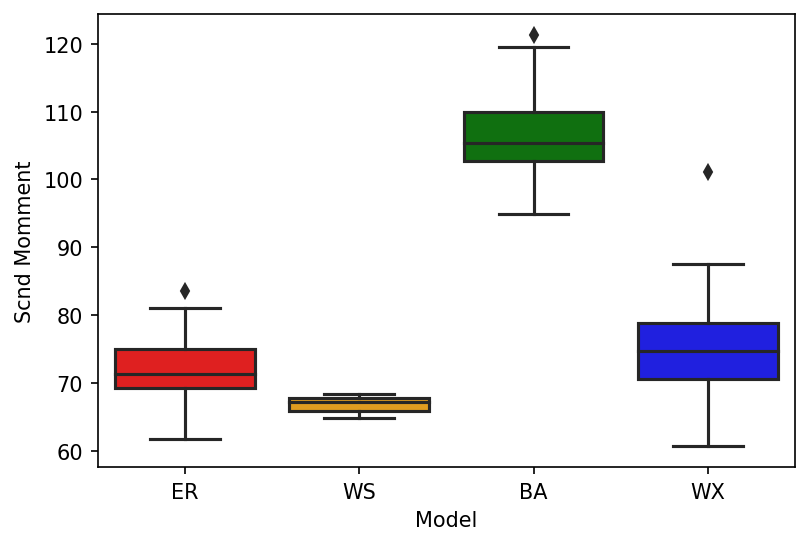

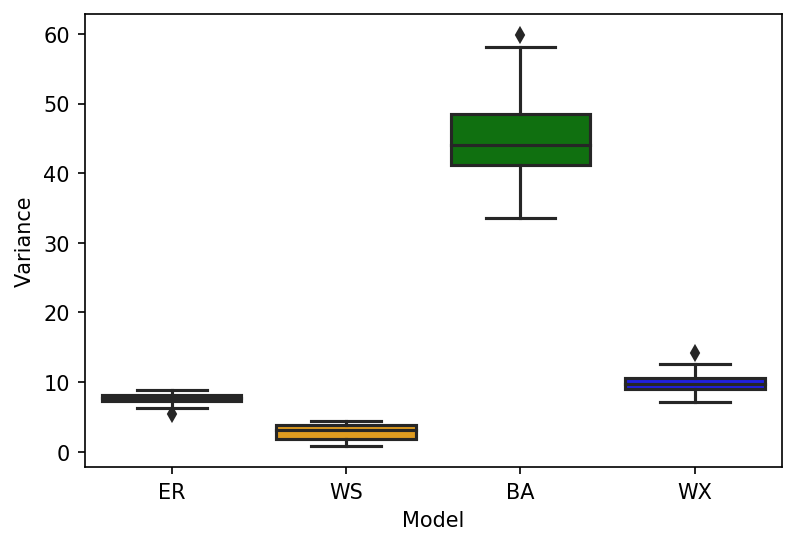

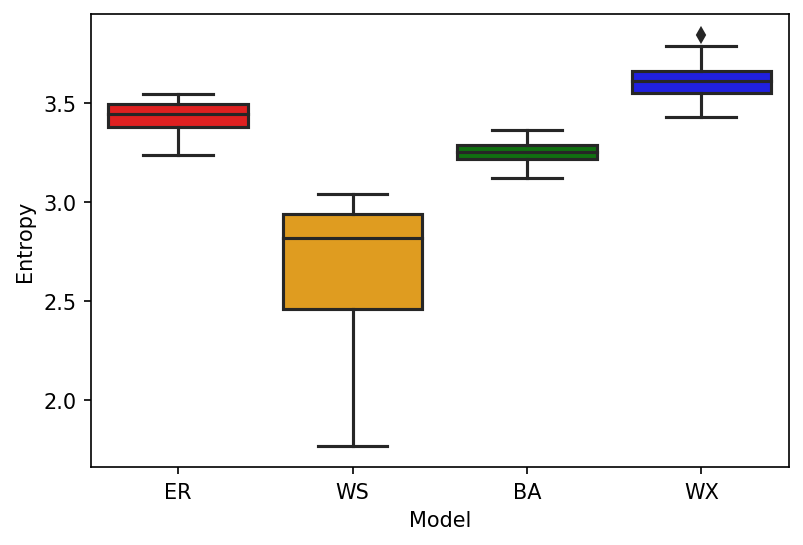

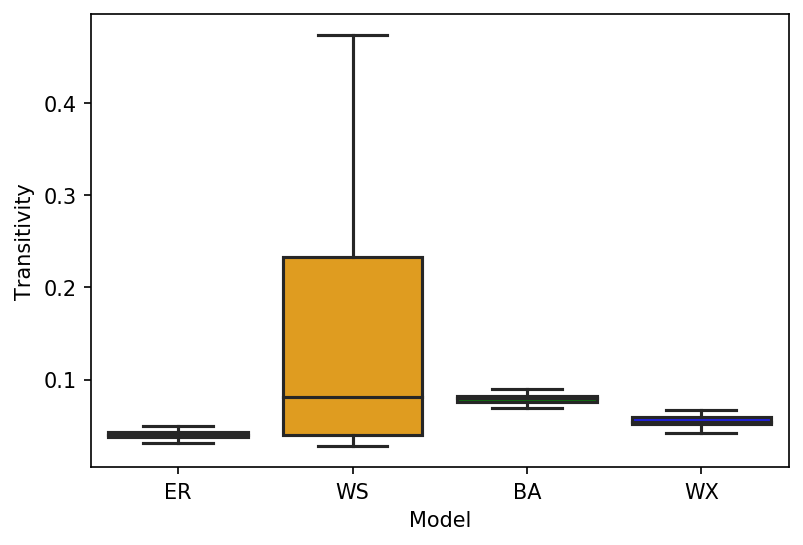

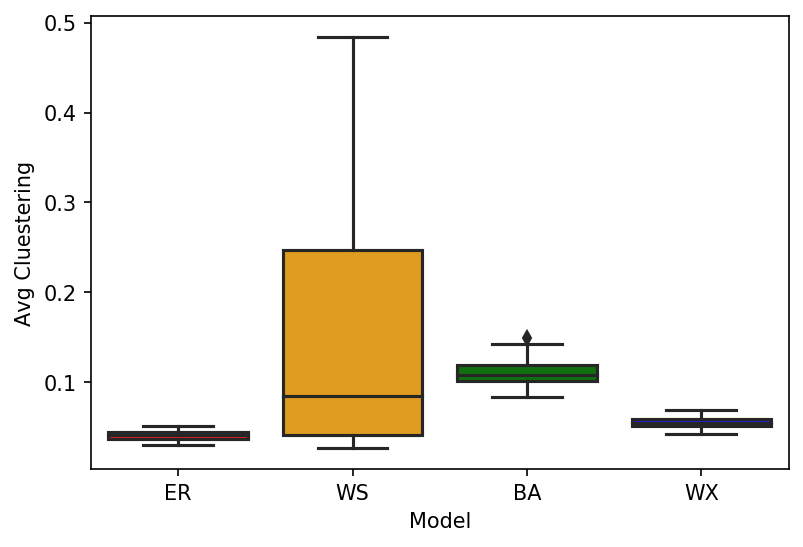

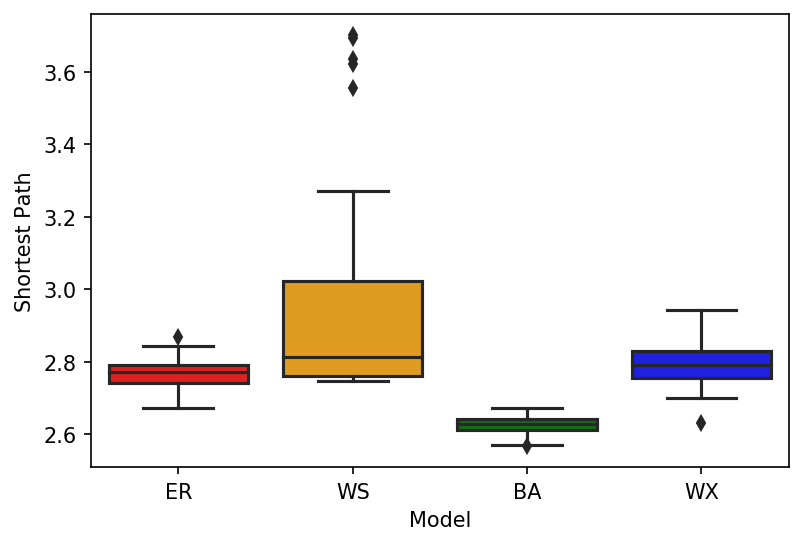

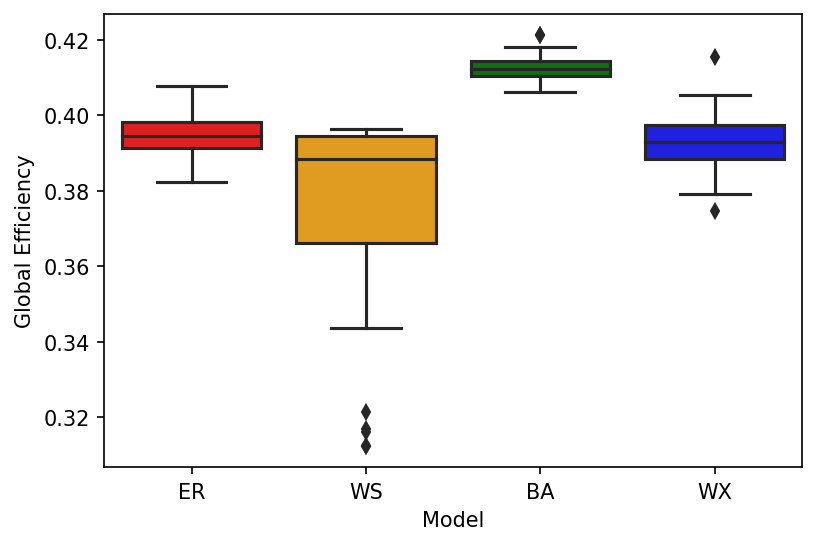

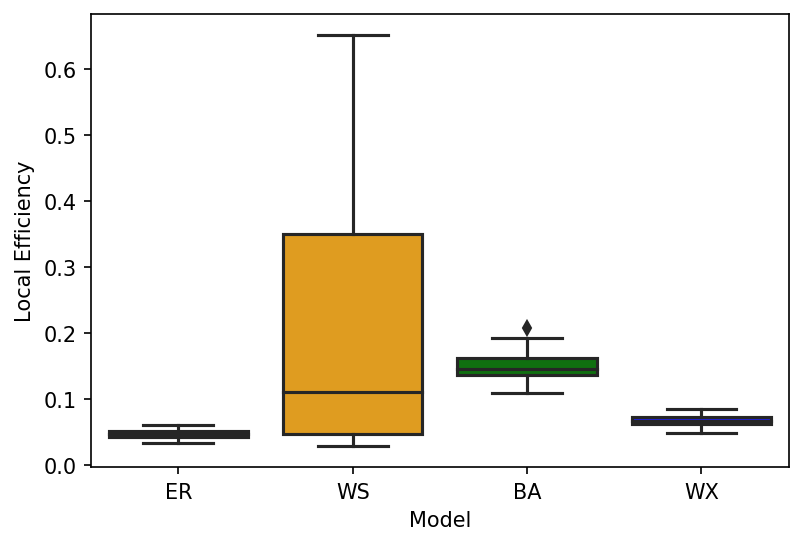

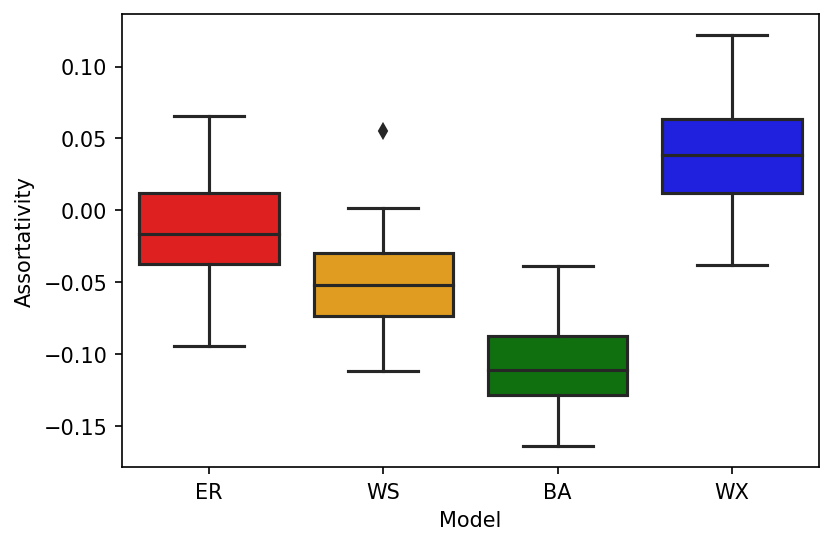

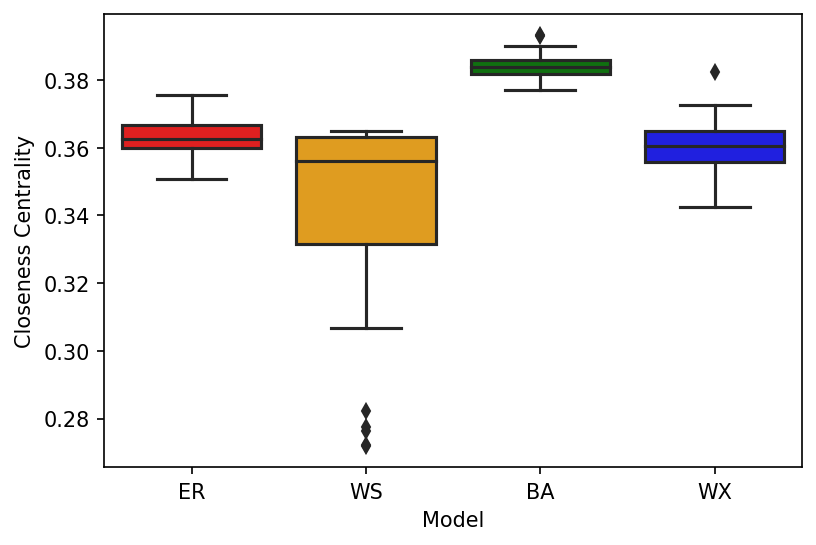

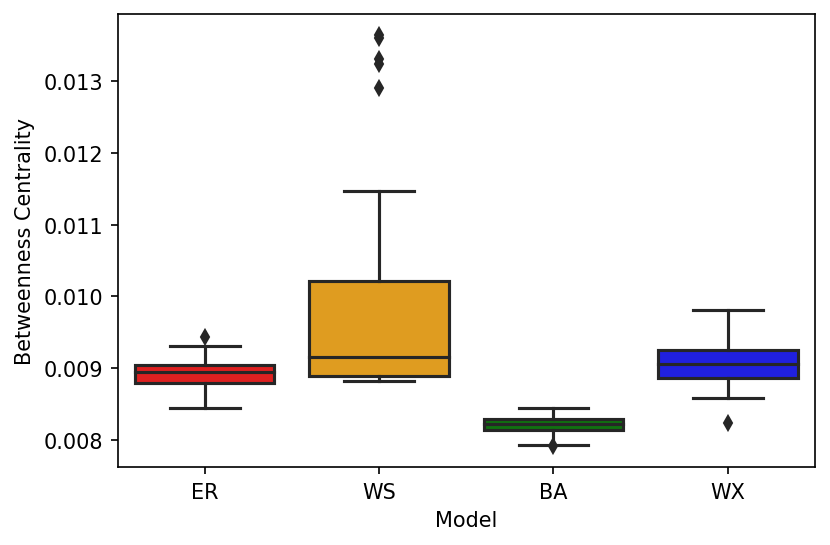

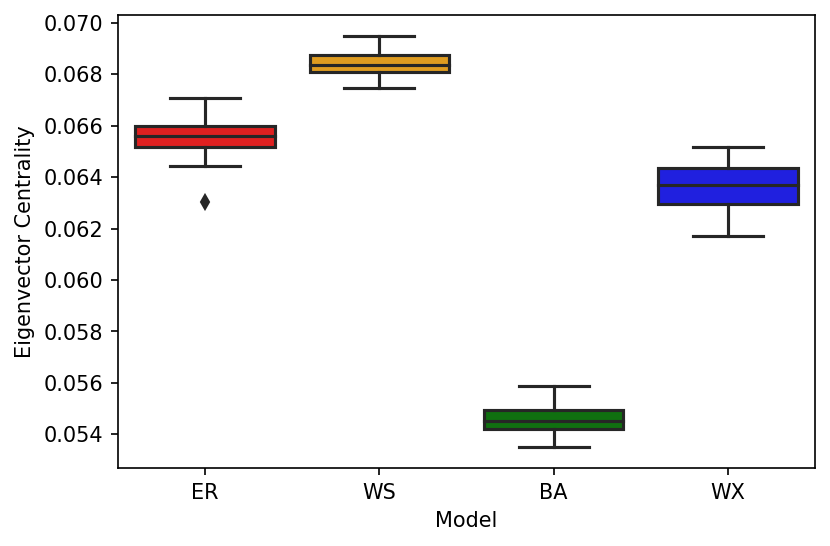

In [9]:
import seaborn as sns
from matplotlib.pyplot import figure

# Obs: não utilizaremos o primeiro momento nos gráficos, pois ele é o grau médio, e nosso intuito é que eles sejam o mais próximos quanto o possível
ppp = ['Scnd Momment', 'Variance', 'Entropy', 'Transitivity',
                                      'Avg Cluestering','Shortest Path', 'Global Efficiency', 'Local Efficiency',
                                      'Assortativity', 'Closeness Centrality', 'Betweenness Centrality',
                                      'Eigenvector Centrality']
#criando um for para plotar um boxplot para cada feature, separados por modelos de redes: 
for i in ppp:
    figure(figsize=(6, 4), dpi=150)
    sns.boxplot(x='Model',y=i,data=a, palette=['r','orange','g','b'])

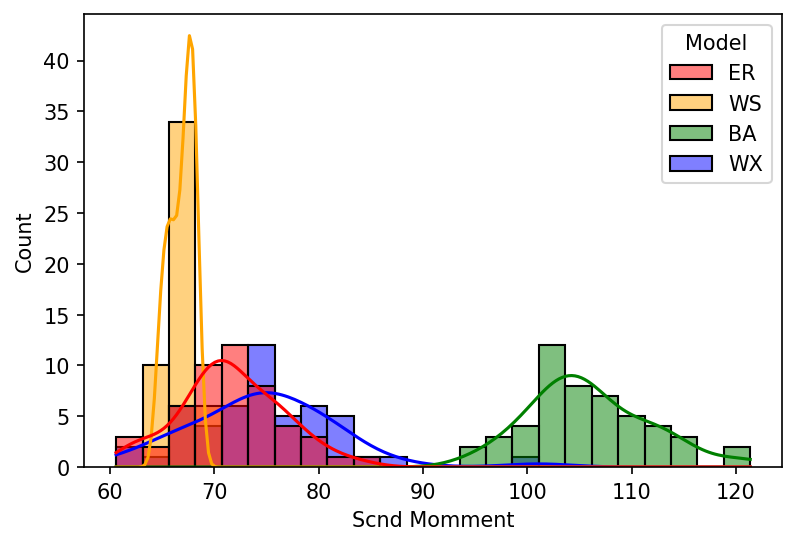

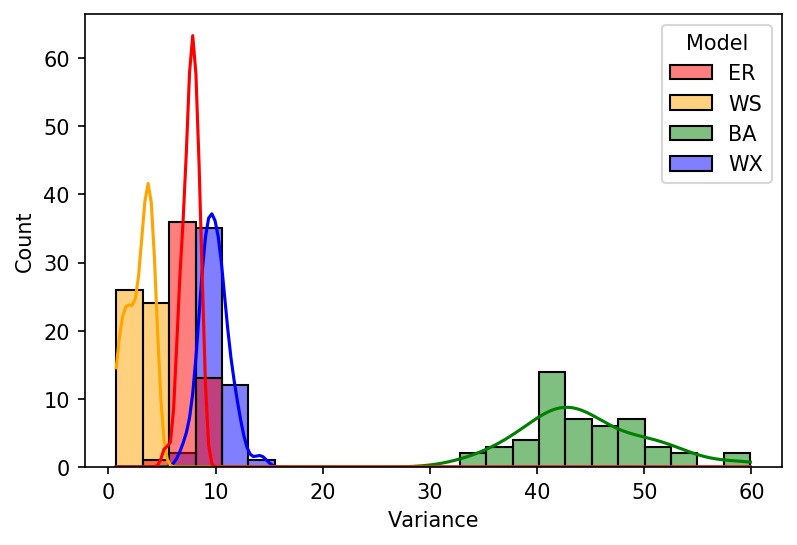

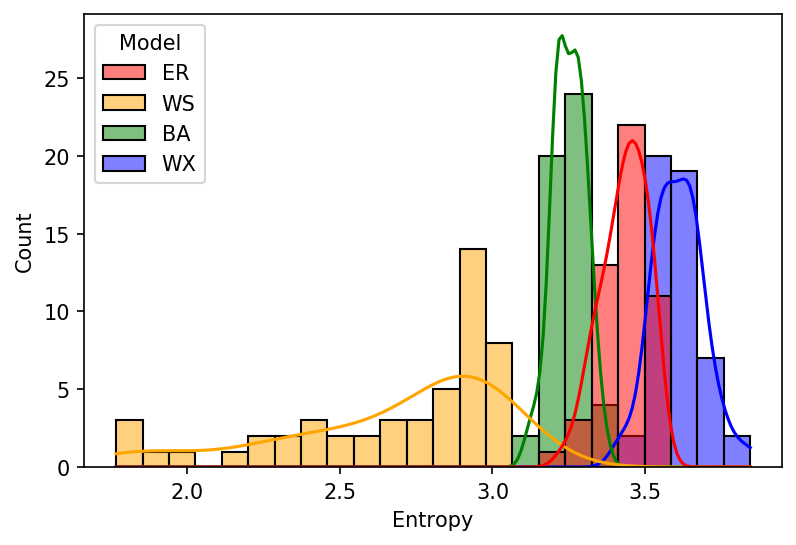

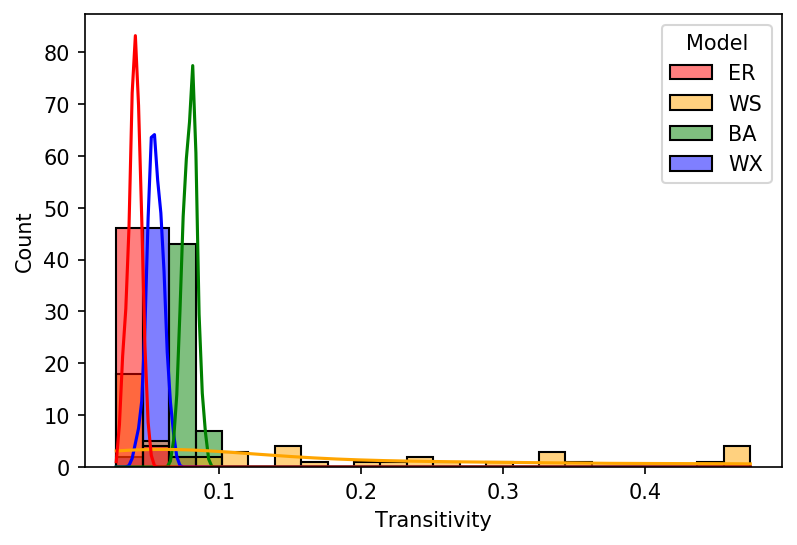

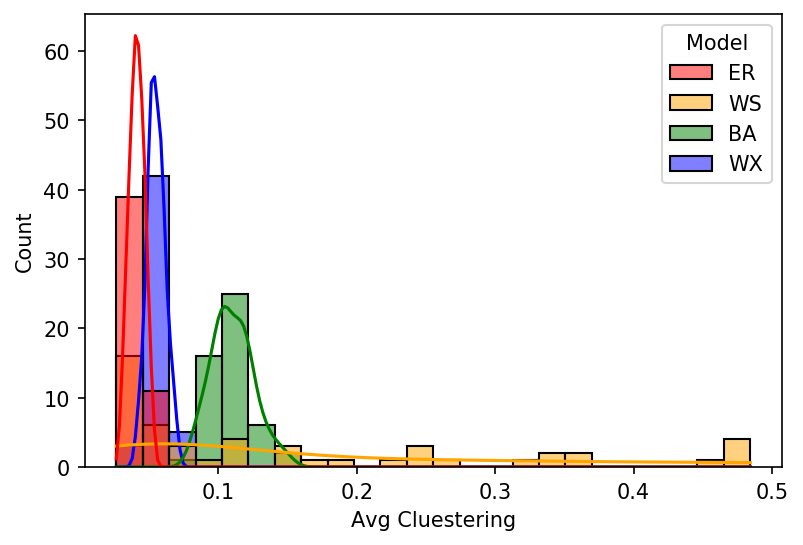

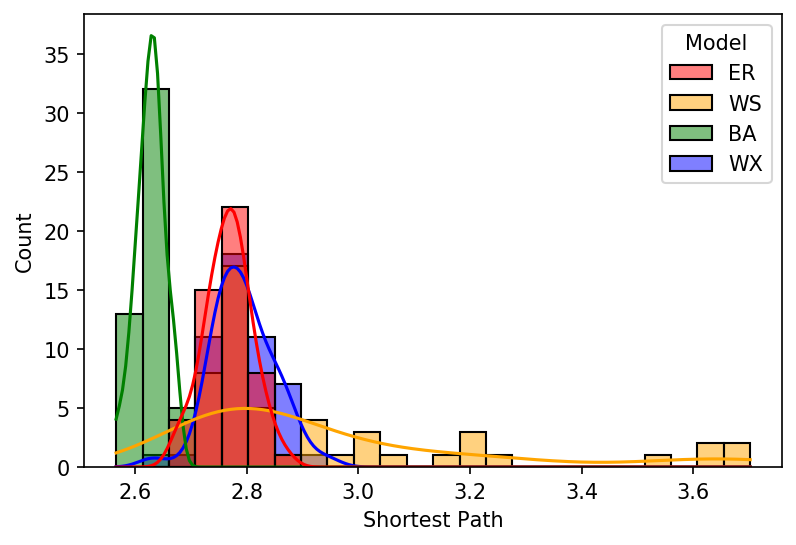

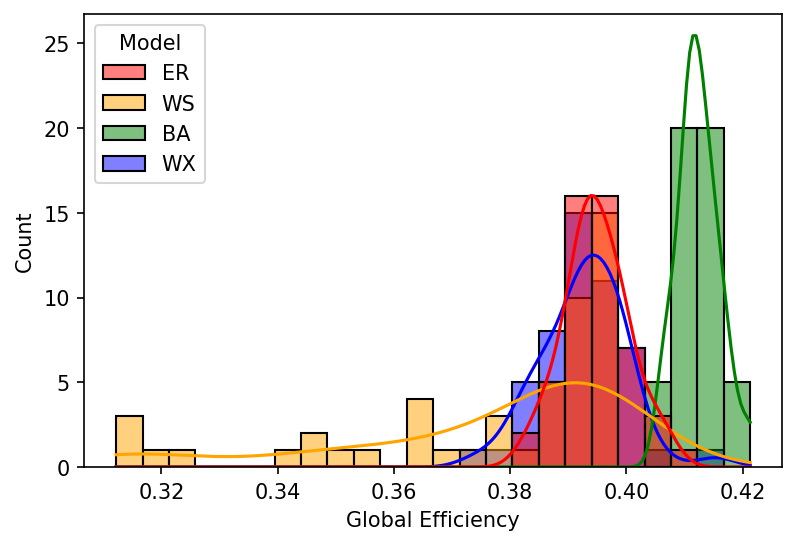

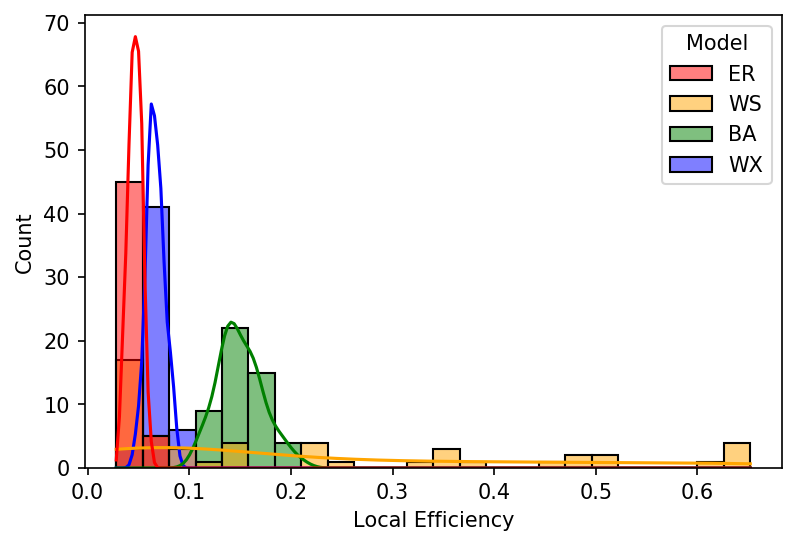

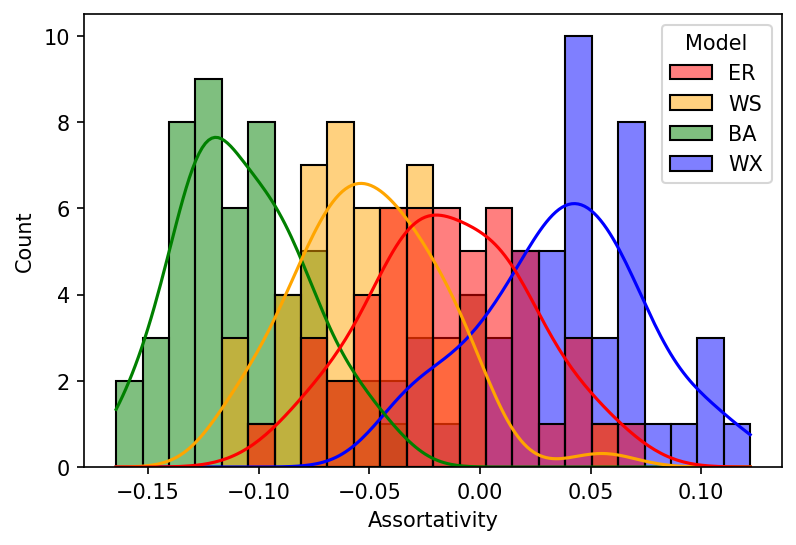

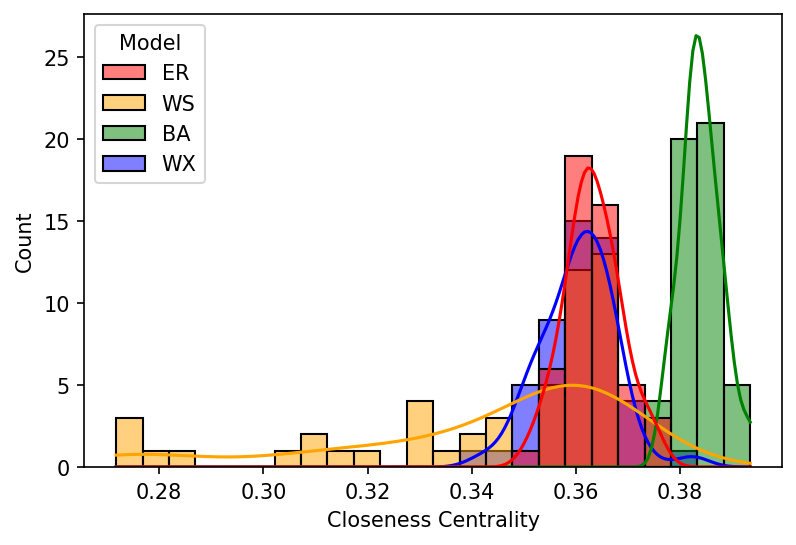

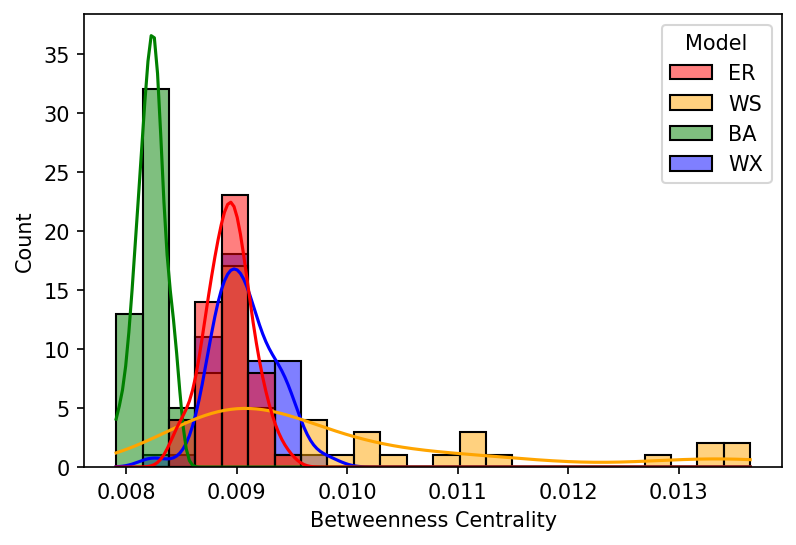

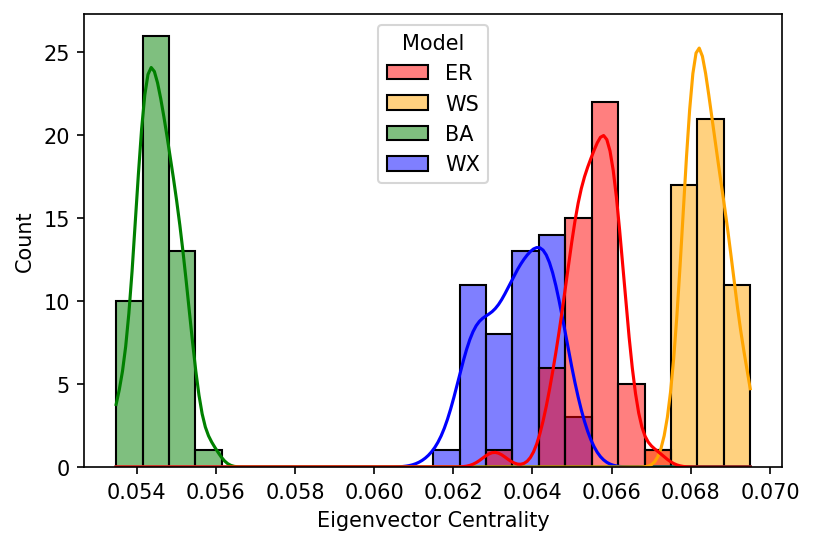

In [10]:
#plotando um histograma com gaussianas para cada uma das features com o intuito de analisar o comportamento dos modelos:
for i in ppp:    
    figure(figsize=(6, 4), dpi=150)
    cmap = sns.color_palette("tab10", as_cmap = True)
    sns.histplot(x = i, data = a, hue='Model',kde=True, bins=24, palette=['r','orange','g','b'])
    plt.show()

Com base nos boxplots e nos gráficos acima, podemos perceber que:

* O modelo Watts-Strogatz(WS) apresenta valores mais "dispersos" em relação aos demais na maioria das medidas, o que pode nos indicar que sua classificação não será tão complicada.

* O modelo Barabási-Albert(BA) apresenta uma maior separação em relação aos demais na maioria das medidas, o que pode nos indicar que sua classificação será mais simples.

* Os modelos Erdos-Renyi(ER) e Waxman(WX) apresentam valores similares na maioria medidas, o que pode ser evidenciado pela sua proximidade e alta área de intersecção entre as gaussianas, o que possivelmente pode representar uma maior dificuldade em sua predição entre si, porém eles conseguem ser evidentemente distintos em relação aos demais modelos, o que, nesse aspecto, torna sua classificação simples.

* A feature Eigenvector Centrality nos mostra o maior grau de separação em relação as demais, é uma forte candidata à ser uma das mais importantes.

* Variance e Eigenvector Centrality aparentam serem suficientes para classificar o modelo Barabási-Albert(BA).

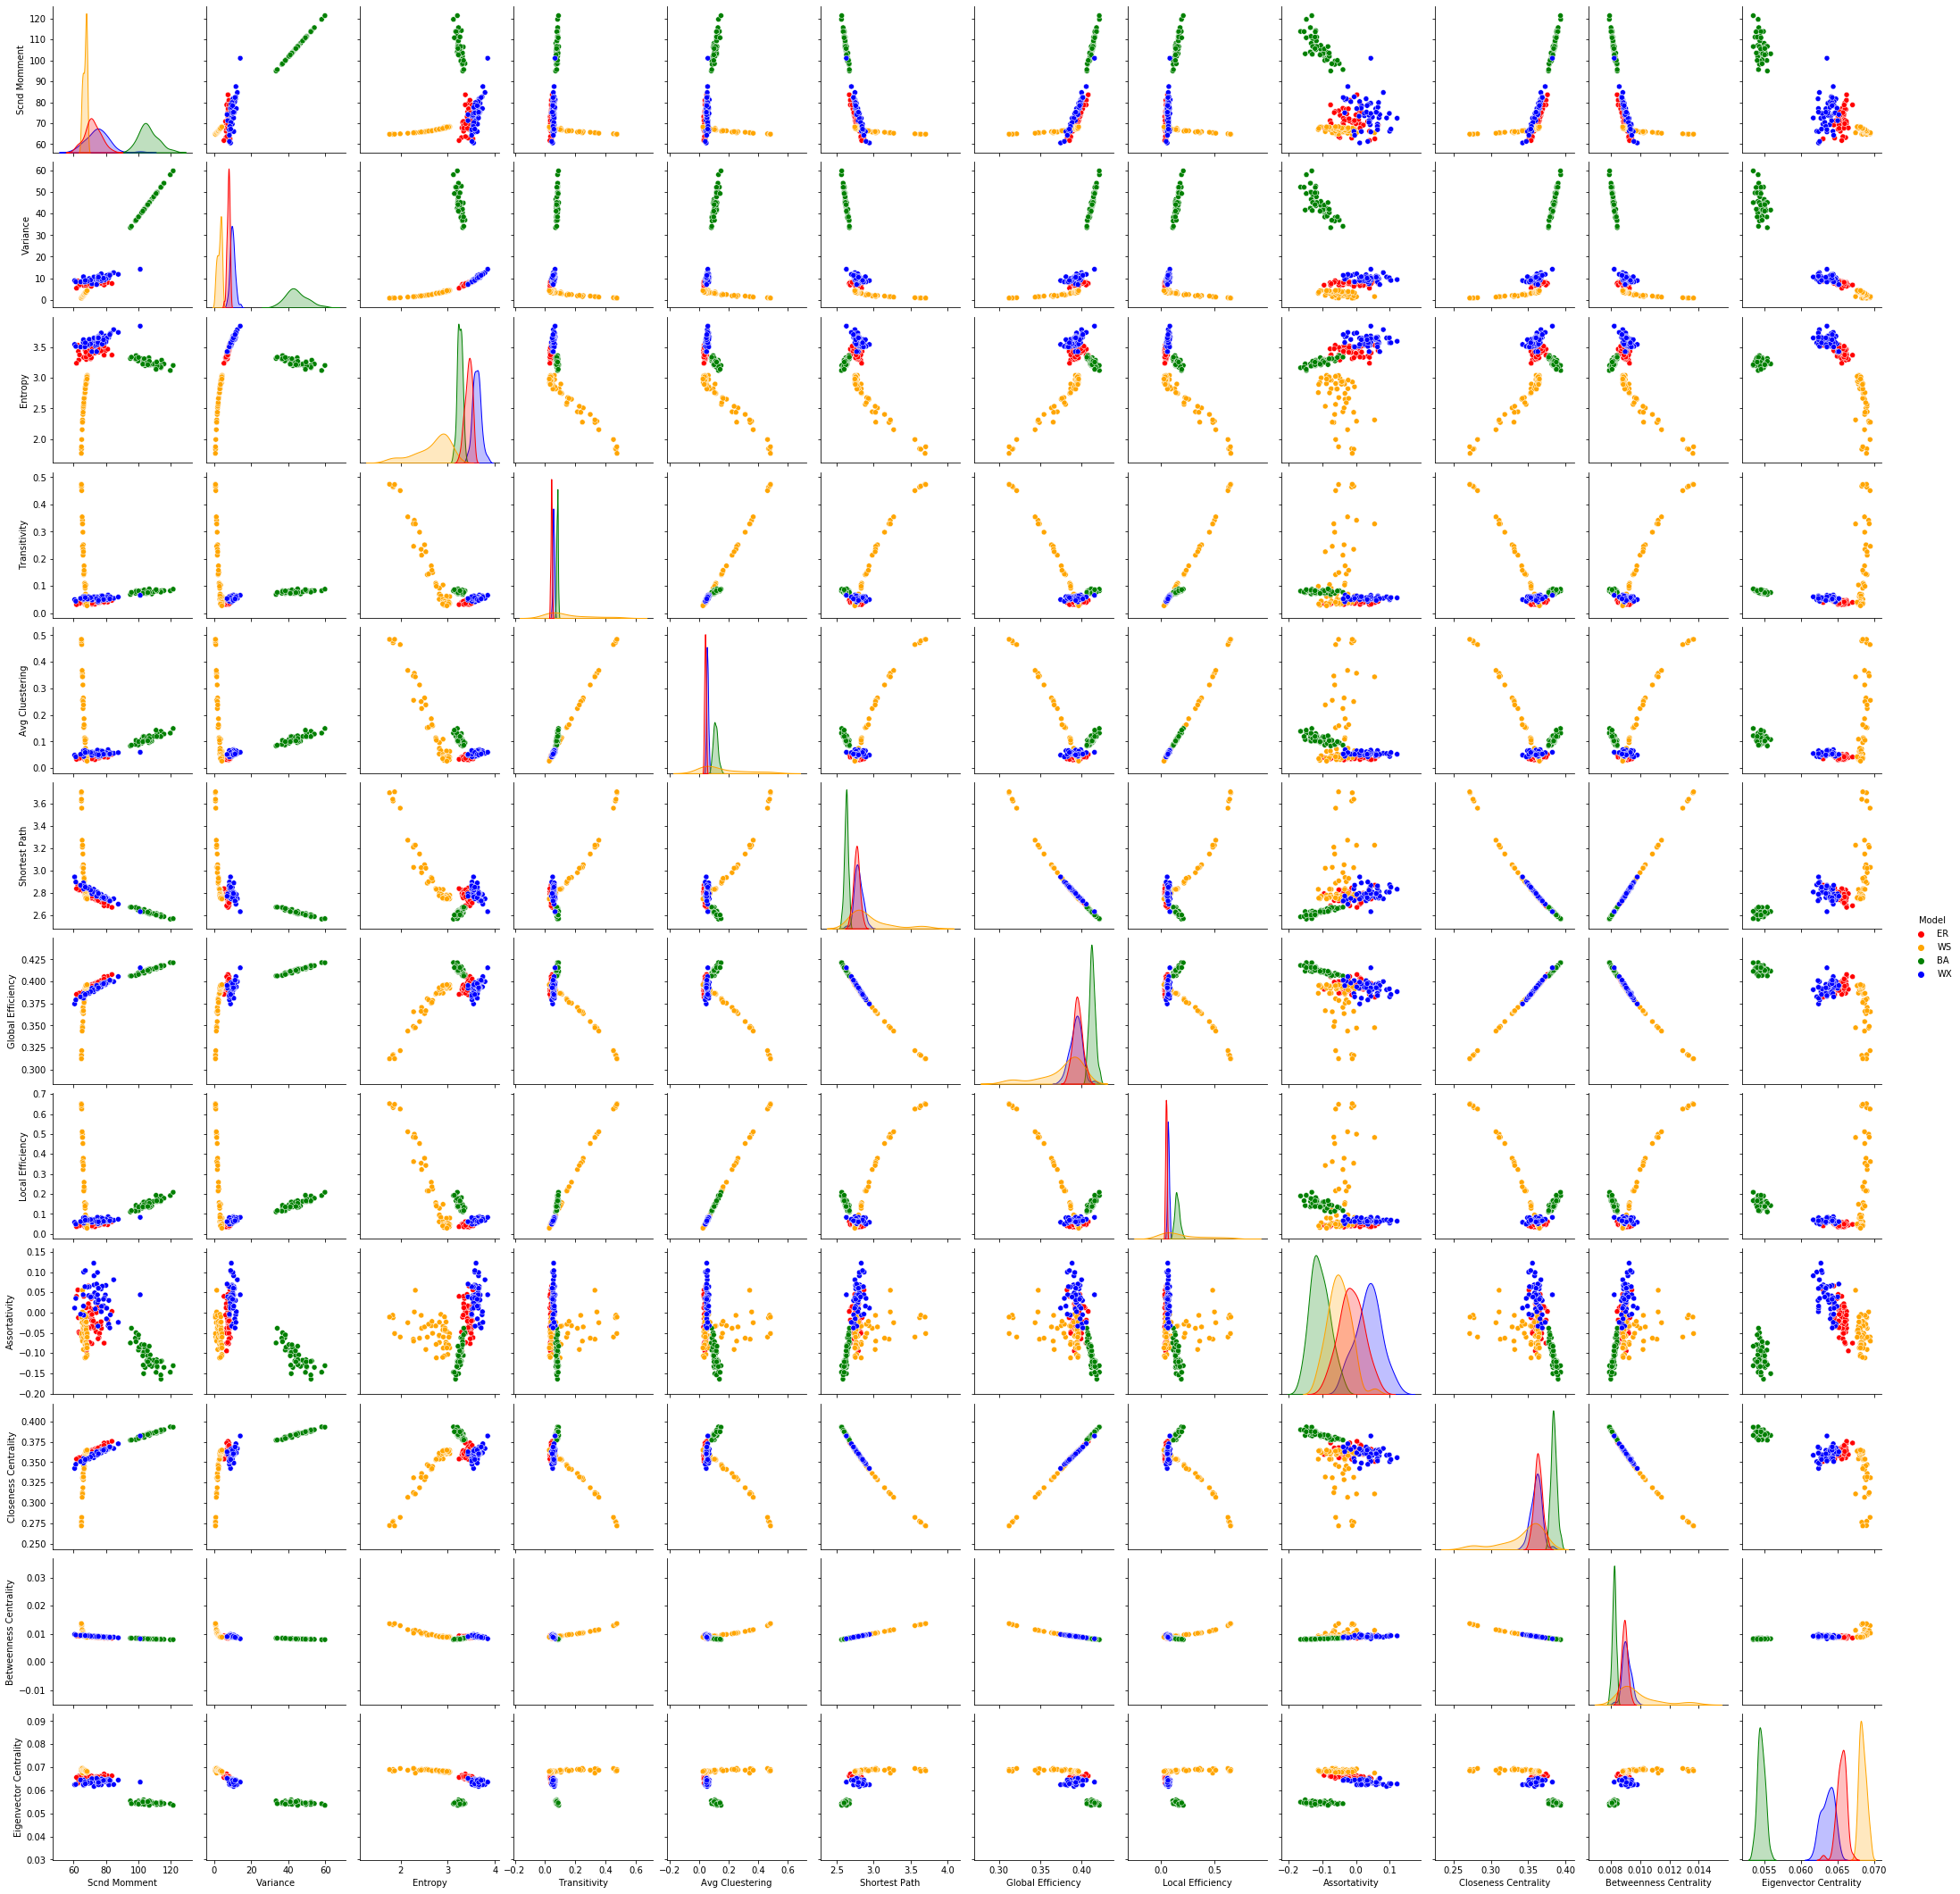

In [11]:
#plotando os pairplots
sns.pairplot(data = a.drop('Frst Momment',1), hue = 'Model', palette=['r','orange','g','b'])

*Obs: é possível dar zoom no pairplot com um double-click.*

Com base no pairplot acima, podemos confirmar as constatações anteriores, que os modelos BA e WS possivelmente terão uma fronteira de decisão bem definida, enquanto os modelos ER e WX apresentam uma maior proximidade, o que pode dificultar sua predição.  

In [12]:
#plotando a matriz de correlação de pearson
figure(figsize=(6, 4), dpi=100)
corr_df = a.corr(method='pearson')

corr_df.style.background_gradient(cmap='coolwarm')

<Figure size 600x400 with 0 Axes>

*Observamos a presença de muitas correlações fortes, o que indica que são altamente dependentes linearmente (provavelmente contêm informações similares) e que ter ambas não é tão relevantes na classificação. Em uma situação padrão, algumas dessas features deveriam ser excluidas (ou alteradas) do treinamento para diminuir o custo computacional, mas esse não é o propósito desse estudo.*

### Testando diferentes modelos de classificação: 

In [13]:
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection 

In [14]:
#função para teste de modelos
def models(X_train, y_train,score):
    clfs = []
    result = []
    names = []
    clfs.append(('CART', DecisionTreeClassifier()))
    clfs.append(('RF', RandomForestClassifier()))
    clfs.append(('EXT', ExtraTreesClassifier()))
    clfs.append(('BAG', BaggingClassifier()))
    clfs.append(('NB', GaussianNB()))
    for algo_name, clf in clfs:
        k_fold = model_selection.KFold(n_splits=10)
        cv_score = model_selection.cross_val_score(clf, X_train, y_train, cv=k_fold, scoring=score)
        result.append((algo_name,cv_score.mean(), cv_score.max(), cv_score.min()))
        names.append(algo_name) 
    return (result)

In [15]:
Xt = a.drop(['Model'],1)
yt = a['Model']

In [16]:
#separando treino e teste
Xt_train,Xt_test,yt_train,yt_test = train_test_split(Xt,yt,test_size=0.25)

In [17]:
models(Xt_train, yt_train, 'accuracy')

[('CART', 0.9666666666666666, 1.0, 0.8666666666666667),
 ('RF', 0.9733333333333334, 1.0, 0.9333333333333333),
 ('EXT', 0.9866666666666667, 1.0, 0.9333333333333333),
 ('BAG', 0.9533333333333334, 1.0, 0.8666666666666667),
 ('NB', 0.9866666666666667, 1.0, 0.9333333333333333)]

Daqui em diante adotaremos o RandomForestClassifier como nosso principal classificador.

Realizando um teste apenas com ele:

In [18]:
import yellowbrick as yb
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def predicao(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    preds = model.predict(X_test)


    accuracy = accuracy_score(y_test, preds)

    print("Acurácia %s" % (accuracy))

    figure(figsize=(6, 4), dpi=150)
    
    cm = ConfusionMatrix(model)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    cm.show()  
    
    figure(figsize=(6, 4), dpi=150)
    visualizer = ClassificationReport(model)
    visualizer.fit(X_train, y_train)        
    visualizer.score(X_test, y_test)        
    visualizer.show()   

Acurácia 0.96


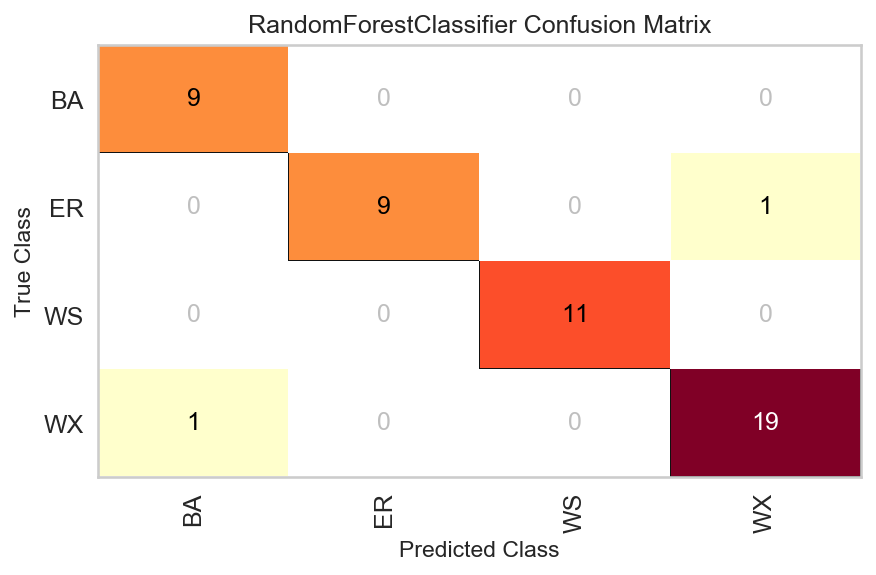

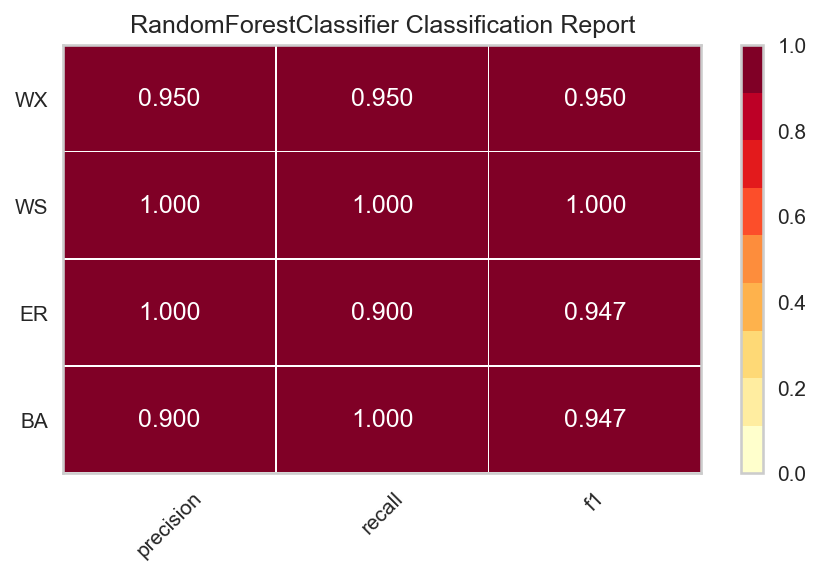

In [19]:
model = RandomForestClassifier(random_state=42)

predicao(model, Xt_train, yt_train, Xt_test, yt_test)

Como previsto anteriormente: 
* Nossos modelos não teriam muitos problemas para prever a classificação dos dados, vendo que todos alcançaram uma boa acurácia.

* Os modelos de Waxman e Erdos-Renyi têm uma fronteira de decisão próxima, porém os classificadores conseguiram lidar bem com isso.

# Criando funções para automatizar o estudo:

In [10]:
#função que plota os grafos:
def plot_graph(G):
    G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    G = nx.convert_node_labels_to_integers(G, first_label=0)

    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color="#8B0000", node_size=50, with_labels=False) 

Com o objetivo de simplificar (ou não puluir demais com informações desnecessárias) os estudos das funções das redes biologicas, sociais e tecnologicas, vamos criar uma única função que nos entregue os outputs desejados, que são:
* Classificação da rede,
* Importância das features na classificação,
* Visualização de um scatterplot do PCA com dois componentes.  

In [15]:
#função para classificar G:
def classify(G):
    av_degree = momment_of_degree_distribution(G,1)#grau médio de G
    N = len(G)
    
    b = medidas(G)
    b = np.array(b).reshape(1,-1)# "tirando as medidas de G" e as deixando no shape para serem classificadas
    
    test = df_creator(N,av_degree,30) #criando o dataset que usaremos para classificar G
    c = len(test)
    
    #Separando a coluna respectiva aos modelos do resto dos dados
    Xt = test.drop(['Model'],1)
    yt = test['Model']
    
    model = RandomForestClassifier(random_state=42)
    model.fit(Xt, yt)
    predicao = model.predict(b) #fazendo a predição com o Random Forest
    
    print('A rede escolhida foi classificada como uma rede ' + '\033[1m' + predicao[0]) #printa a predição
    print('\033[0m')
    
    return model, Xt, yt, b, c

In [22]:
#função que calcula a feature importance:
def feat_import(model,Xt): #recebe o algoritmo de classificação e o conjunto dos dados    
    importances = model.feature_importances_
    attributes = Xt.columns
    indices = np.argsort(importances)
    attributes_rank = []
    
    fig = plt.figure(figsize = (6,4), dpi=100)
    plt.grid()
    
    for i in indices:
        attributes_rank.append(attributes[i])
    plt.title('Importância dos atributos',fontsize=25)
    plt.tight_layout()
    plt.barh(range(len(indices)), importances[indices], color='#8B0000', align='center')
    plt.yticks(range(len(indices)), attributes_rank, fontsize=25)
    plt.xticks(color='k', size=17)
    plt.yticks(color='k', size=17)
    plt.xlim([0, 0.3])
    plt.show()

In [23]:
#função para plotar o PCA com dois componentes para uma melhor vizualização do nosso target:
def PCA_plot(b,Xt,yt,c):
    Target = list(b[0])
    Xt.loc[c] = Target
    
    scaler = StandardScaler()
    Xt = scaler.fit_transform(Xt) #padroniza os dados
    
    pca = PCA(n_components=2)
    pc = pca.fit_transform(Xt) #aplica o PCA com dois componentes
    
    pcDf = pd.DataFrame(data = pc, columns = ['pc 1', 'pc 2'])#trasforma em dataframe
    
    yt = pd.DataFrame(yt,columns=['Model'])#transforma yt em dataframe
    
    v = ['Target']
    df = pd.DataFrame(v,columns=['Model'])
    yt = pd.concat([yt, df], ignore_index=True)#junta nosso target ao yt
    
    DF= pd.concat([pcDf, yt], axis = 1) #gera um dataframe final
    
    #plota o pca com 2 componentes do nosso modelo:
    fig = plt.figure(figsize = (6,4), dpi=150)
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('PC 1', fontsize = 15)
    ax.set_ylabel('PC 2', fontsize = 15)
    ax.set_title('PCA', fontsize = 20)
    targets = ['ER', 'WS', 'BA', 'WX', 'Target']
    colors = ['r', 'orange', 'g','b', 'black']
    for target, color in zip(targets,colors):
        indicesToKeep = DF['Model'] == target
        ax.scatter(DF.loc[indicesToKeep, 'pc 1']
                   , DF.loc[indicesToKeep, 'pc 2']
                   , c = color
                   , s = 120)
    ax.legend(targets)
    ax.grid()
    plt.show()

In [13]:
#função final que combina todas as anteriores (com cronometro):
def ClassificationAnalysis(G):
    inicio = time.perf_counter() #inicio da cronometragem
    
    model, Xt, yt, b, c = classify(G)
    
    feat_import(model,Xt)
    PCA_plot(b,Xt,yt,c)
    
    fim = time.perf_counter() #fim da cronometragem
    
    print(f"Tempo de execução de {fim - inicio:0.4f} segundos")

**Validação:**

Como o modelo Erdos-Renyi é um dos com fronteira de decisão aparentemente não bem definida, o utilizaremos para validar o nosso algoritmo final (ClassificationAnalysis). 

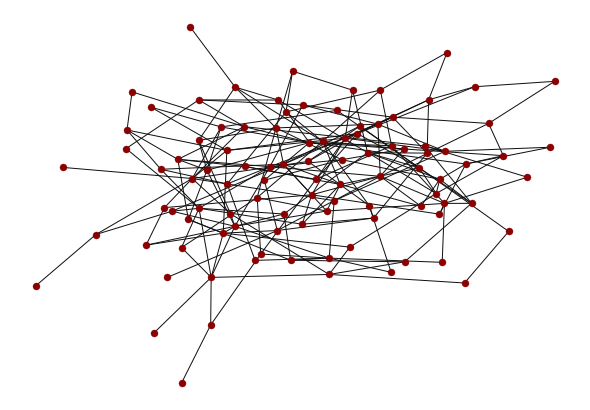

In [27]:
GER = nx.gnp_random_graph(100, 4/(100-1), seed=None, directed=False)
Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
GER = GER.subgraph(Gcc[0])
GER = nx.convert_node_labels_to_integers(GER, first_label=0)

plot_graph(GER)

A rede escolhida foi classificada como uma rede ER



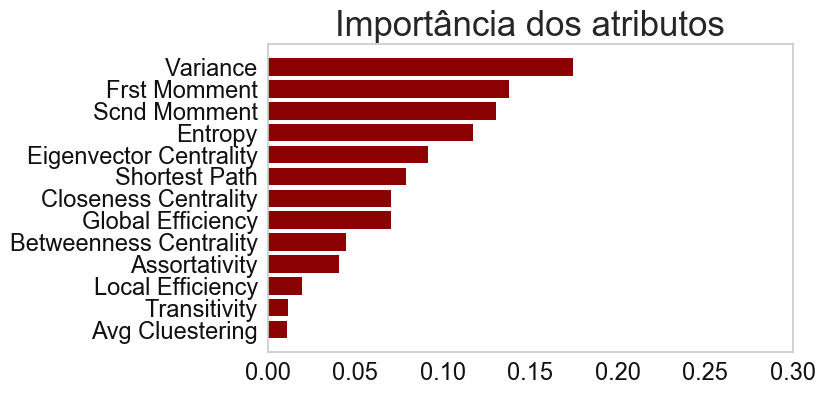

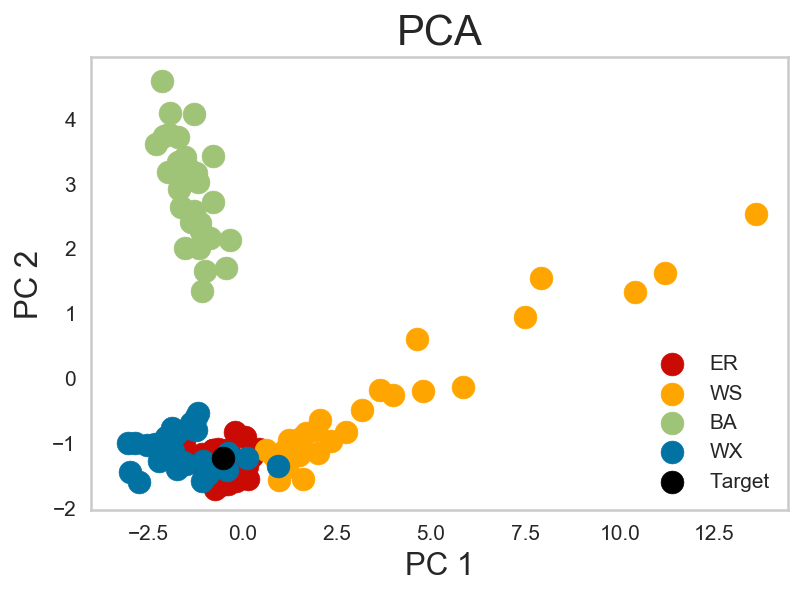

Tempo de execução de 32.7539 segundos


In [28]:
ClassificationAnalysis(GER)

Vemos que nosso algoritmo está funcionando corretamente.

# Avaliando as redes escolhidas:

Como tudo parece OK, começaremos nossos estudos das 9 redes escolhidas.

# Redes Biológicas:

## 1 - Rede celegansneural — C. elegans neurons (1986):

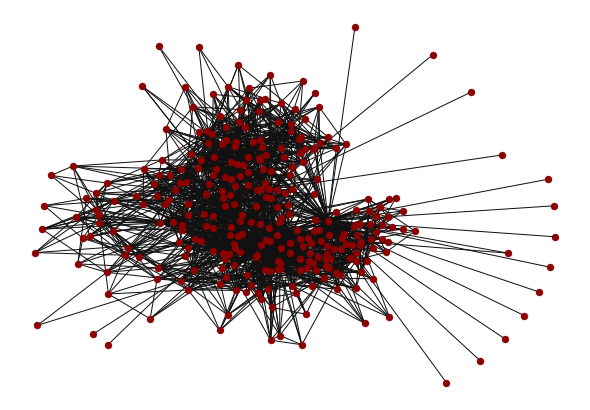

In [29]:
G = nx.read_edgelist(r"C:\Users\avale\data\bio.csv", nodetype=int,delimiter=",", data=(('weight',float),))
plot_graph(G)

A rede escolhida foi classificada como uma rede BA



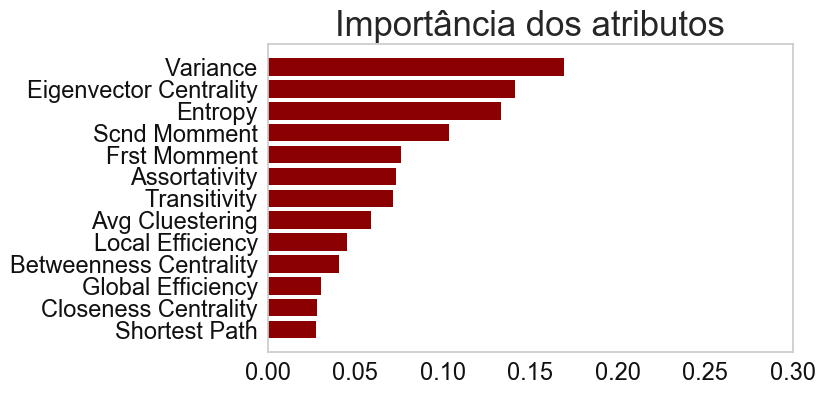

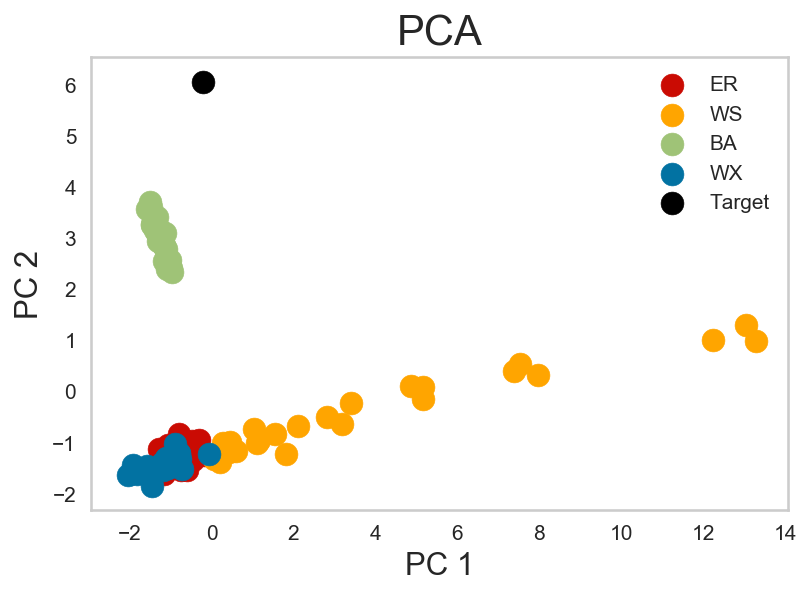

Tempo de execução de 432.2001 segundos


In [30]:
ClassificationAnalysis(G)

*Observamos a partir do scatterplot acima, que realmente há uma proximidade maior entre a nossa rede target e o cluster do modelo Barabasi-Albert.*

## 2- Rede cintestinalis — Tadpole larva brain (C. intestinalis):

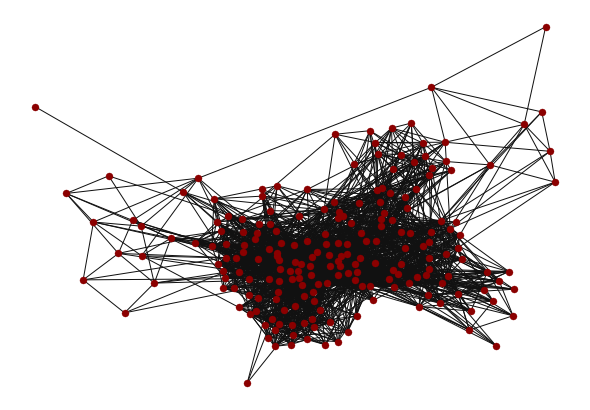

In [31]:
G = nx.read_edgelist(r"C:\Users\avale\data\cintestinals.csv", nodetype=int,delimiter=",", data=(('depth',float),))
plot_graph(G)

A rede escolhida foi classificada como uma rede BA



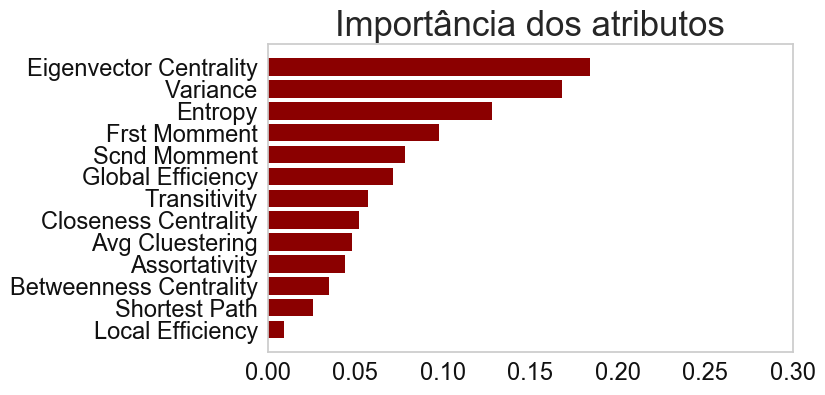

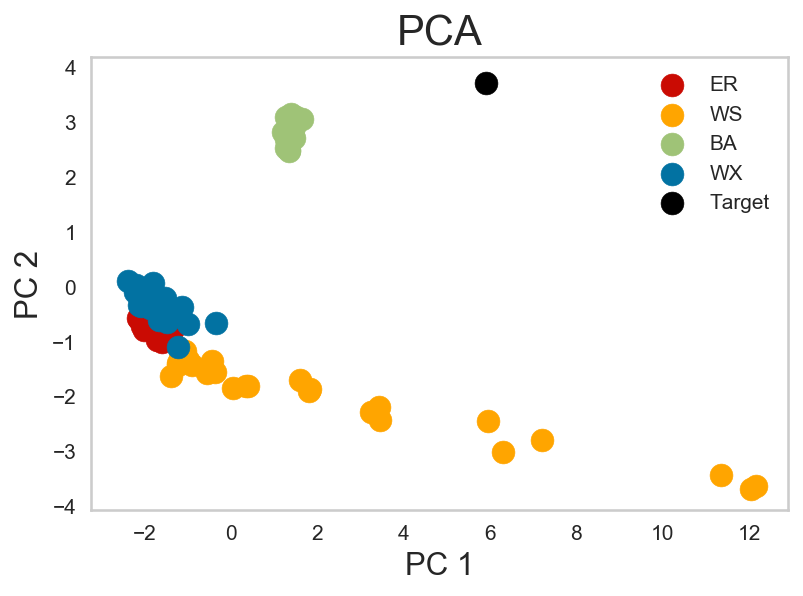

Tempo de execução de 549.4913 segundos


In [32]:
ClassificationAnalysis(G)

*Observamos a partir do scatterplot acima, que realmente há uma proximidade maior entre a nossa rede target e o cluster do modelo Barabasi-Albert.*

## 3 - Rede foodweb_baywet — Florida cypress wetlands food web (1998):

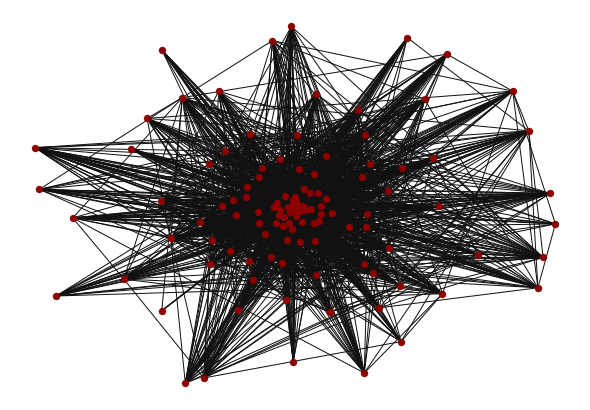

In [35]:
G = nx.read_edgelist(r"C:\Users\avale\data\florida.csv", nodetype=int,delimiter=",", data=(('weight',float),))
plot_graph(G)

A rede escolhida foi classificada como uma rede BA



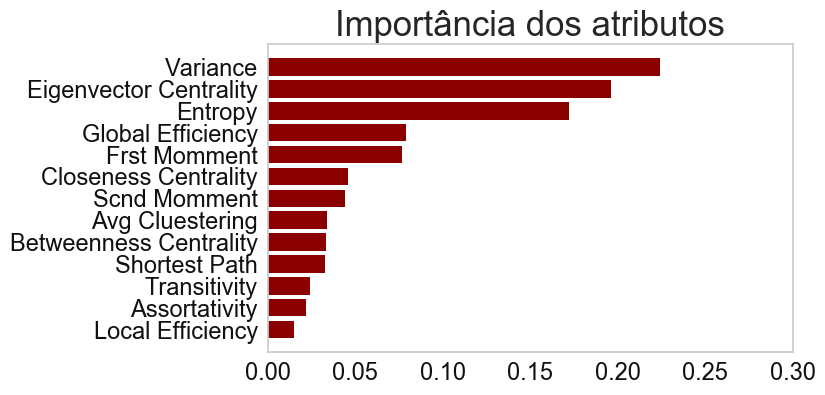

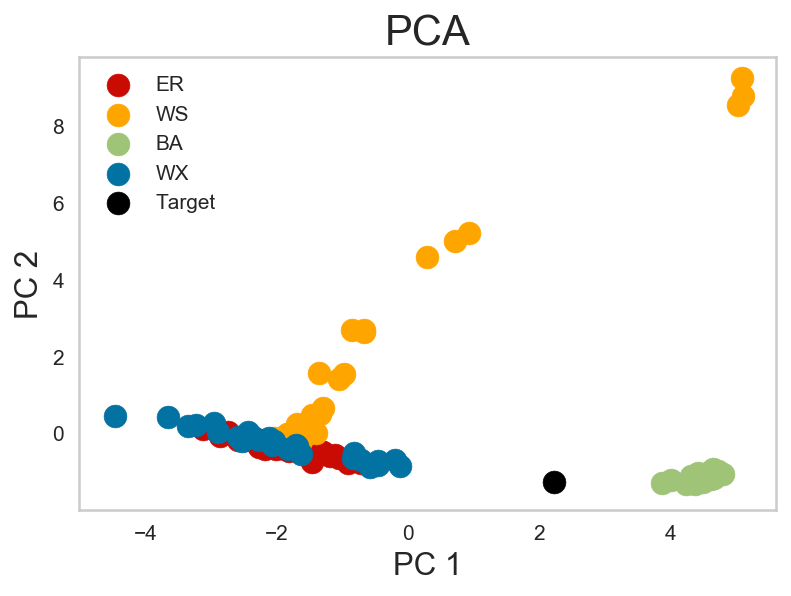

Tempo de execução de 556.7312 segundos


In [36]:
ClassificationAnalysis(G)

No scatterplot vemos uma proximidade similar dos clusters dos modelos Barabasi-Albert e Waxman.

# Redes Sociais:

## 1 - Rede jazz_collab — Jazz collaboration network:

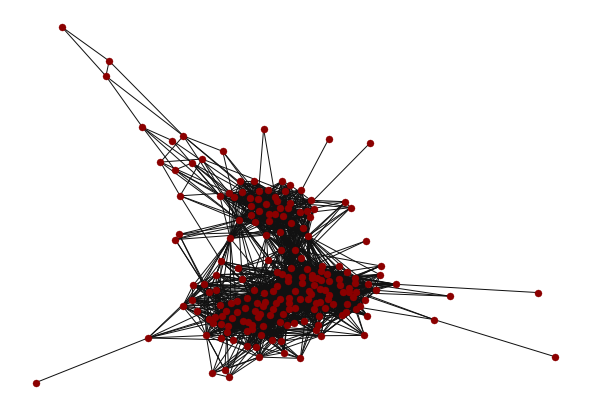

In [45]:
G = nx.read_edgelist(r"C:\Users\avale\data\jazzcollab.csv", nodetype=int,delimiter=",")
plot_graph(G)

A rede escolhida foi classificada como uma rede BA



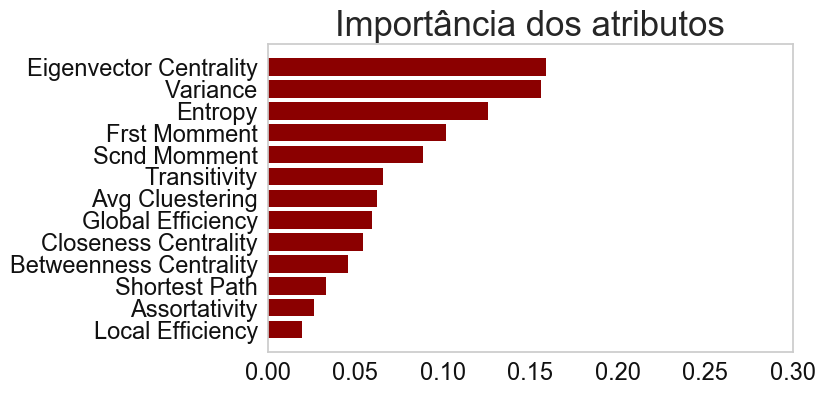

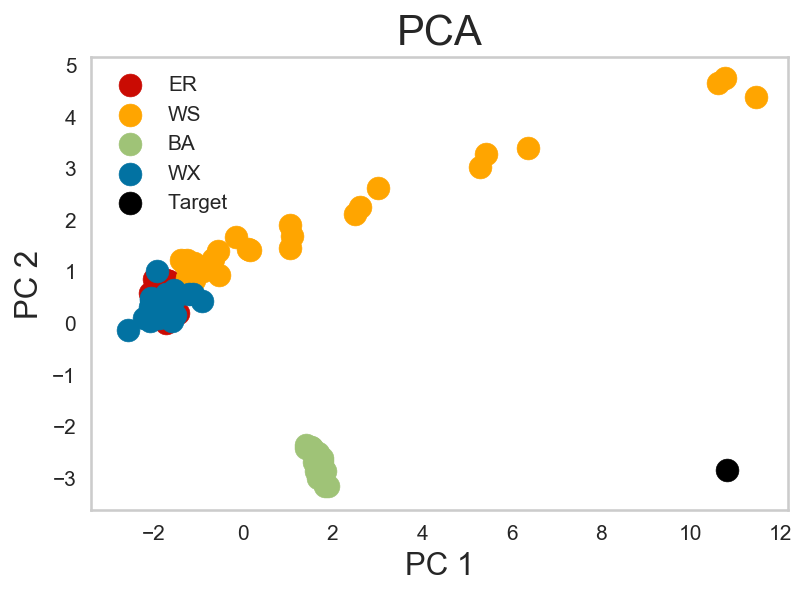

Tempo de execução de 625.6255 segundos


In [46]:
ClassificationAnalysis(G)

## 2 - Rede football — NCAA college football 2000:

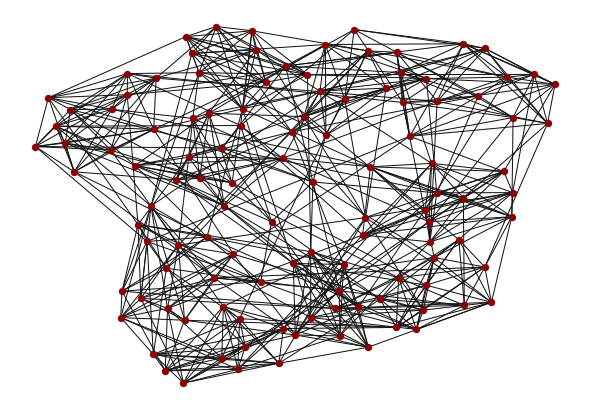

In [41]:
G = nx.read_edgelist(r"C:\Users\avale\data\football.csv", nodetype=int,delimiter=",")
plot_graph(G)

A rede escolhida foi classificada como uma rede WS



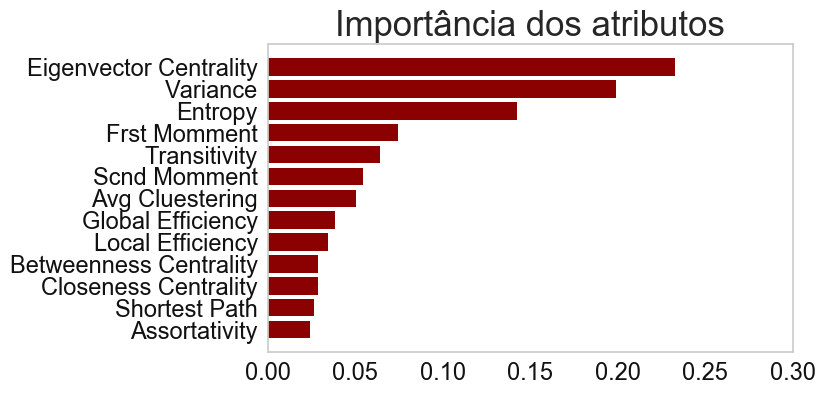

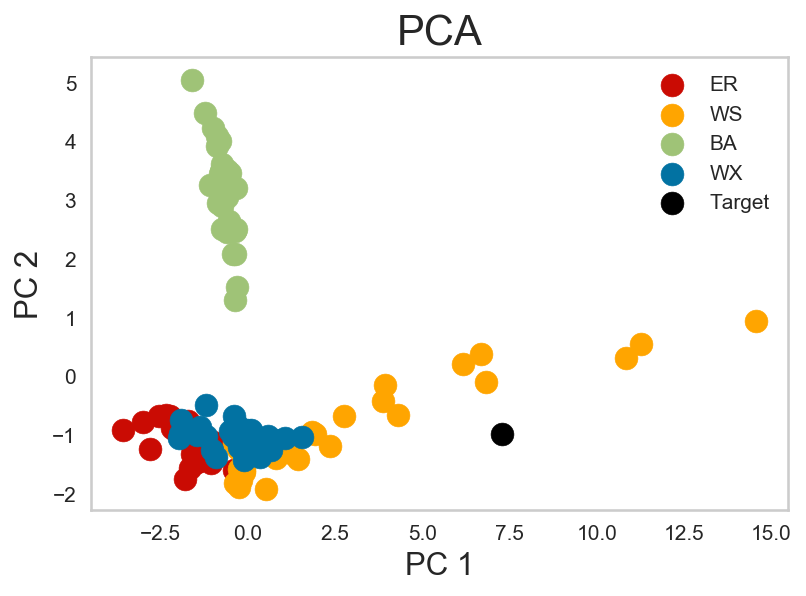

Tempo de execução de 60.4089 segundos


In [42]:
ClassificationAnalysis(G)

Observamos no scatterplot que o nossa rede target tem visível proximidade com o modelo Watts-Strogatz.

## 3 - Rede revolution — American Revolutionary groups (1765-1783):

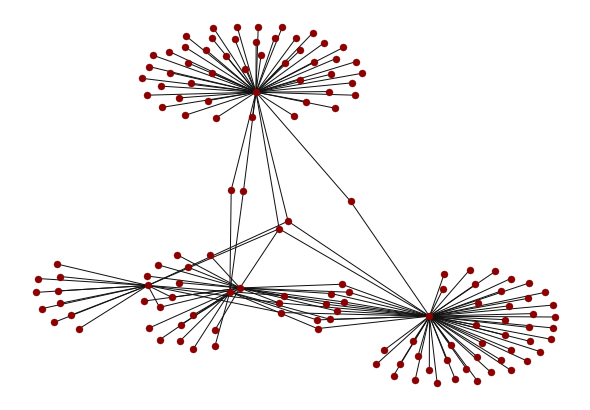

In [43]:
G = nx.read_edgelist(r"C:\Users\avale\data\revolution.csv", nodetype=int,delimiter=",")
plot_graph(G)

A rede escolhida foi classificada como uma rede BA



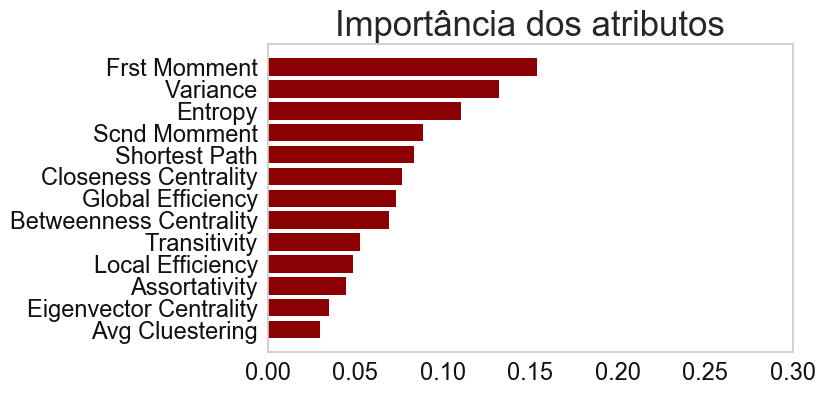

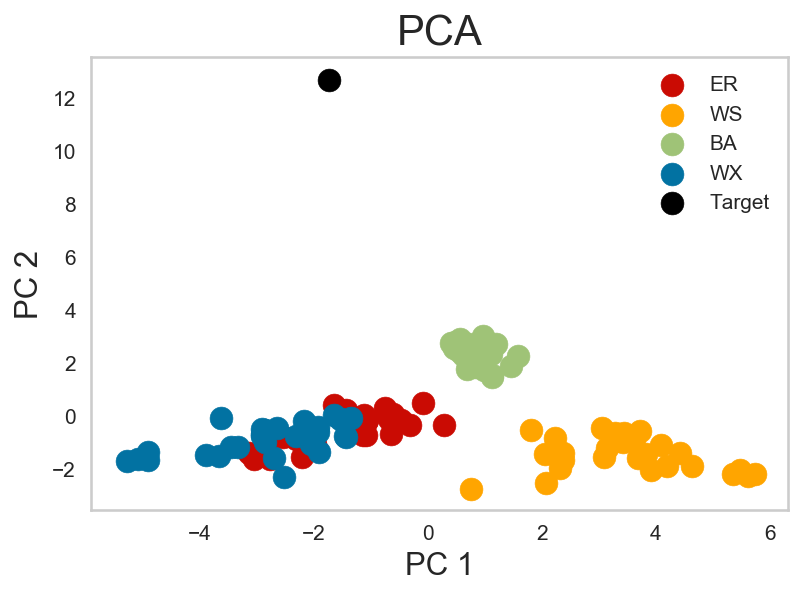

Tempo de execução de 60.0233 segundos


In [44]:
ClassificationAnalysis(G)

No scatter plot vemos uma certa distância, porém visualmente podemos perceber uma semelhança a uma Barabasi-Albert de mesmo grau médio e tamanho, que se caracteriza por seus hubs.

# Redes Tecnológicas:

## 

In [31]:
G = nx.read_edgelist(r"C:\Users\dougl\Desktop\Faculdade\1ºsemestre 2021\Redes complexas\dados_classificação\edges_palmetto.csv", nodetype=int, delimiter=",",id = 'int')


TypeError: read_edgelist() got an unexpected keyword argument 'id'

In [22]:
ClassificationAnalysis(G)

NetworkXError: Graph is not connected.